In [ ]:
# Install and upgrade jovian package silently
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 432.5 kB/s eta 0:00:00


In [ ]:
# Importing necessary libraries
import os  # For interacting with the operating system, e.g., file paths
import random  # For generating random numbers
import numpy as np  # For numerical operations on large arrays/matrices
import pandas as pd  # For data manipulation and analysis
import shutil  # For file operations like copying and removing files

# For plotting and visualising data
from matplotlib import pyplot as plt
# For image processing tasks
from PIL import Image

# To handle file system paths in a way that works on different operating systems
from pathlib import Path

# Importing PyTorch libraries
import torch  # For creating and training neural networks
import torchvision  # For working with image datasets and pre-trained models
import torchvision.transforms as T  # For data augmentation and transformations
import torchvision.datasets as datasets  # For standard datasets like CIFAR-10, MNIST
from torchvision.io import read_image  # For reading images

# Set a fixed seed for reproducibility of results
torch.manual_seed(42)

# Importing jovian for logging and sharing the notebook
import jovian

# Importing the ZipFile module for handling zip files
from zipfile import ZipFile

### Downlading the dataset from kaggle

In [ ]:
# Downloading the dataset from Kaggle
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 774M/778M [00:05<00:00, 138MB/s]
100% 778M/778M [00:05<00:00, 157MB/s]


### Unzipping the folder and extracting the images

In [ ]:
# Extracting the zip files from the downloaded dataset

# Specifying the name of the zip file downloaded from Kaggle
file = "covid19-radiography-database.zip"

# Opening the zip file in read mode
with ZipFile(file, 'r') as z:
    # Listing all the contents of the zip file (optional, useful for verifying the contents)
    z.printdir()

    # Extracting all files to the current directory
    print('Extracting all the files...')
    z.extractall()  # Extracts to the current working directory
    print('Extraction complete!')

Streaming output truncated to the last 5000 lines.
COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png 2022-03-19 13:41:48         1507
COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png 2022-03-19 13:41:48         1453
COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png 2022-03-19 13:41:48         1435
COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png 2022-03-19 13:41:48         1663
COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png 2022-03-19 13:41:48         1374
COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png 2022-03-19 13:41:48         1522
COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png 2022-03-19 13:41:48         1350
COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png 2022-03-19 13:41:48         1516
COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png 2022-03-19 13:41:48         1607
COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png 2022-03-19 13:41:48         1536
COVID-19_Radiography_Dataset/Normal/mask

### Removing the unwanted files and folders

In [ ]:
# Removing unwanted 'masks' directories in each dataset class folder
!sudo rm -r ./COVID-19_Radiography_Dataset/COVID/masks
!sudo rm -r ./COVID-19_Radiography_Dataset/Normal/masks
!sudo rm -r ./COVID-19_Radiography_Dataset/Viral\ Pneumonia/masks

def move_images(source_dir, target_dir):
    for file_name in os.listdir(source_dir):
        source_path = os.path.join(source_dir, file_name)
        shutil.move(source_path, target_dir)

# Move images from 'images' subdirectories to main directories
move_images("/content/COVID-19_Radiography_Dataset/COVID/images", "/content/COVID-19_Radiography_Dataset/COVID/")
move_images("/content/COVID-19_Radiography_Dataset/Normal/images", "/content/COVID-19_Radiography_Dataset/Normal/")
move_images("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images", "/content/COVID-19_Radiography_Dataset/Viral Pneumonia/")

# Remove now-empty 'images' directories
!sudo rm -r ./COVID-19_Radiography_Dataset/COVID/images
!sudo rm -r ./COVID-19_Radiography_Dataset/Normal/images
!sudo rm -r ./COVID-19_Radiography_Dataset/Viral\ Pneumonia/images
!sudo rm -r ./COVID-19_Radiography_Dataset/Lung_Opacity/
!sudo rm ./COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx

### Setting up the base folders and root directories as per the dataset received.

In [ ]:
# Define the root directory of the dataset and the new base directory
root_dir = 'COVID-19_Radiography_Dataset'
base_dir = '/content/covid-19/'

# Renaming the root directory to a new base directory
os.rename(root_dir, base_dir)

# Define source and target directories for the 'Normal' class
norm_source = '/content/covid-19/Normal'
norm_class = '/content/covid-19/normal'

# Define source and target directories for the 'COVID' class
covid_source = '/content/covid-19/COVID'
covid_class = '/content/covid-19/covid'

# Define source and target directories for the 'Viral Pneumonia' class
pneumonia_source = '/content/covid-19/Viral Pneumonia'
viral_class = '/content/covid-19/viral'

# Renaming the class directories to simpler, lowercase names
os.rename(norm_source, norm_class)
os.rename(covid_source, covid_class)
os.rename(pneumonia_source, viral_class)

# Removing unnecessary files and directories
!sudo rm -rf ./covid-19/.ipynb_checkpoints/  # Removes Jupyter notebook checkpoint files
!sudo rm -r ./covid-19/COVID.metadata.xlsx  # Removes metadata file for COVID images
!sudo rm -r ./covid-19/Normal.metadata.xlsx  # Removes metadata file for Normal images
!sudo rm -r ./covid-19/Viral\ Pneumonia.metadata.xlsx  # Removes metadata file for Viral Pneumonia images
!sudo rm -r ./covid-19/README.md.txt  # Removes README file

### Making dataframe of labels and filepath

In [ ]:
# Initialise an empty list to store image file paths and their corresponding labels
images_path = []

# Loop through each class directory in the base directory
for classes in os.listdir(base_dir):
    # Exclude the 'test' directory and files with extensions 'xlsx' and 'txt'
    if classes != 'test' and os.path.isdir(os.path.join(base_dir, classes)):
        # Construct the full path to the class directory
        classes_path = os.path.join(base_dir, classes)
        print(classes_path)  # Optionally print the path for debugging

        # Loop through each image file in the class directory
        for images in os.listdir(classes_path):
            # Append the full image path and its corresponding class label to the list
            images_path.append([os.path.join(classes_path, images), classes])

/content/covid-19/normal
/content/covid-19/covid
/content/covid-19/viral


In [ ]:
# An example entry in the list (e.g., 2001st entry)
images_path[1267]

['/content/covid-19/normal/Normal-6107.png', 'normal']

In [ ]:
# Create a dataframe from the list of image paths and labels
df = pd.DataFrame(images_path, columns=['Filepath', 'label'])

# Displaying the dataframe
print(df.head())

                                   Filepath   label
0  /content/covid-19/normal/Normal-3728.png  normal
1  /content/covid-19/normal/Normal-2799.png  normal
2  /content/covid-19/normal/Normal-3045.png  normal
3  /content/covid-19/normal/Normal-4371.png  normal
4  /content/covid-19/normal/Normal-2122.png  normal


In [ ]:
# Filter the dataframe for indices corresponding to each class label
normal_df = df[df['label'] == 'normal'].index
covid_df = df[df['label'] == 'covid'].index
viral_df = df[df['label'] == 'viral'].index

### Downsampling Images for Normal Class

In [ ]:
# Ensure there are enough samples in 'normal_df' before sampling
if len(normal_df) >= 3616:
    # Randomly select 3616 indices from the 'normal' class without replacement
    selected_normal_inds = np.random.choice(normal_df, 3616, replace=False)
else:
    raise ValueError("Not enough samples in 'normal_df' to select 3616.")

# Concatenate the selected 'normal' indices with all 'covid' and 'viral' indices
indices = np.concatenate([selected_normal_inds, covid_df, viral_df])

# Creating a new dataframe that contains only the selected indices
final_df = df.loc[indices]

# Displaying the final dataframe
print(final_df.head())

                                      Filepath   label
5700  /content/covid-19/normal/Normal-9004.png  normal
131   /content/covid-19/normal/Normal-3590.png  normal
2846  /content/covid-19/normal/Normal-1122.png  normal
8477  /content/covid-19/normal/Normal-3264.png  normal
9522  /content/covid-19/normal/Normal-3308.png  normal


#### **final_df now has 3616 normal images, 3616 covid images and 1345 pneumonia images**

### Image Visualisation for Pre-processing

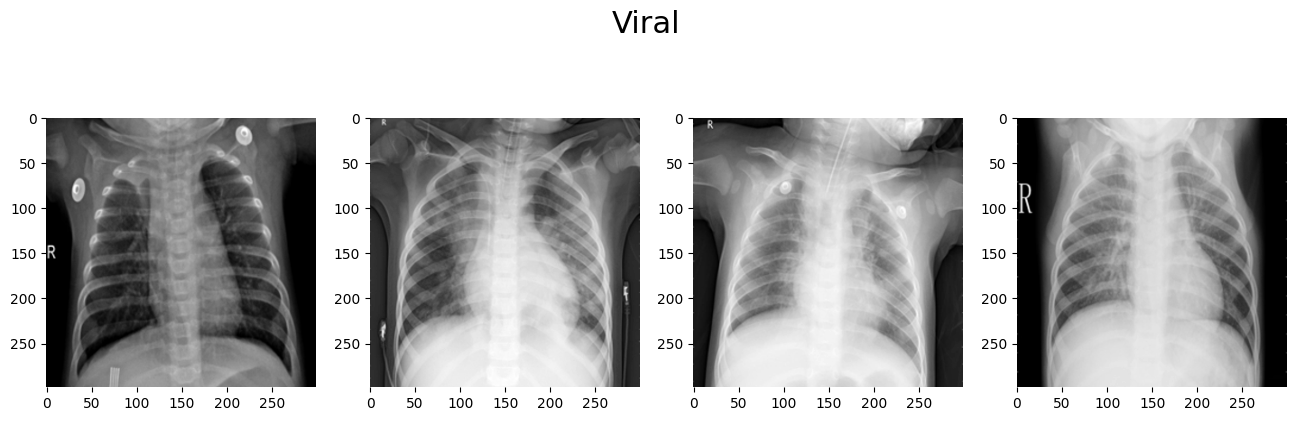

In [ ]:
# Define the directory path for viral images
viral = '/content/covid-19/viral/'

# Get a list of all image file names in the 'viral' directory
img_paths = os.listdir(viral)

# Create a figure with a specified size for displaying the images
fig = plt.figure(figsize=(16, 5))
fig.suptitle("Viral", size=22)  # Add a title to the figure

# Loop through the first 4 images in the 'viral' directory
for i, image in enumerate(img_paths[:4]):
    # Read the image using torchvision's read_image function
    img = read_image(os.path.join(viral, image))

    # Convert the tensor image to a PIL image for visualization
    img = T.ToPILImage()(img)

    # Create a subplot for each image
    plt.subplot(1, 4, i + 1, frameon=False)

    # Display the image in grayscale
    plt.imshow(img, cmap='gray')

# Display the figure with the images
plt.show()

### Image plotting function

In [ ]:
# Plots a grid of images with optional titles and original images included
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):

    # Ensure imgs is a list of lists
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)  # Number of rows
    num_cols = len(imgs[0]) + with_orig  # Number of columns, including original image if applicable

    # Create a subplot grid
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)

    # Iterate over each row and column to plot images
    for row_idx, row in enumerate(imgs):
        # Prepend the original image if with_orig is True
        row = [orig_img] + row if with_orig else row

        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            # Display the image using imshow
            ax.imshow(np.asarray(img), cmap='gray', **imshow_kwargs)
            # Remove axis ticks and labels
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    # Set the title for the original image
    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)

    # Set row titles if provided
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    # Adjust layout for better spacing
    plt.tight_layout()

# Set default figure size for plots
plt.rcParams["figure.figsize"] = (20, 3)

# Single Transform done to compare Original Image with Final Image

In [ ]:
# Apply a given transform to an image multiple times and plot the results
def apply_and_plot_transform(transform, orig_img, n_times=3, title=None):

    transformed_images = [transform(orig_img) for _ in range(n_times)]
    plot(transformed_images, row_title=[title] if title else None)

orig_img = Image.open(viral + img_paths[0])

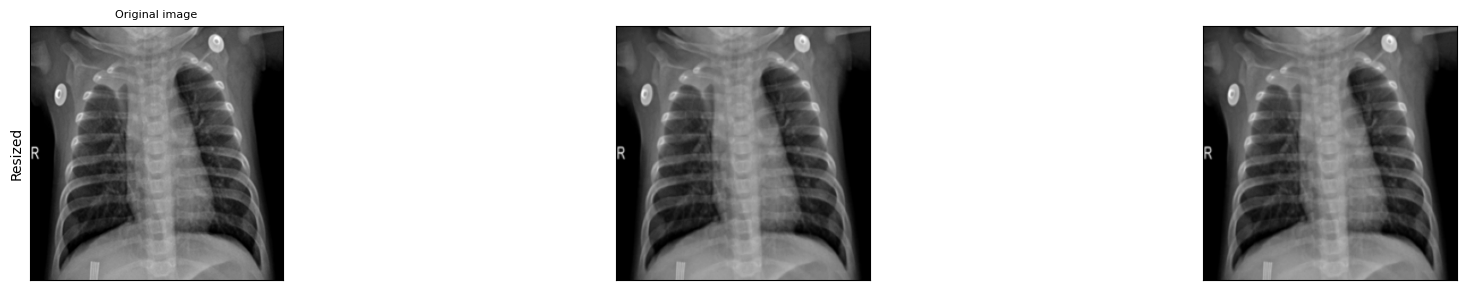

In [ ]:
# Apply and plot resize transformation
apply_and_plot_transform(T.Compose([T.Resize(224)]), orig_img, n_times=2, title='Resized')

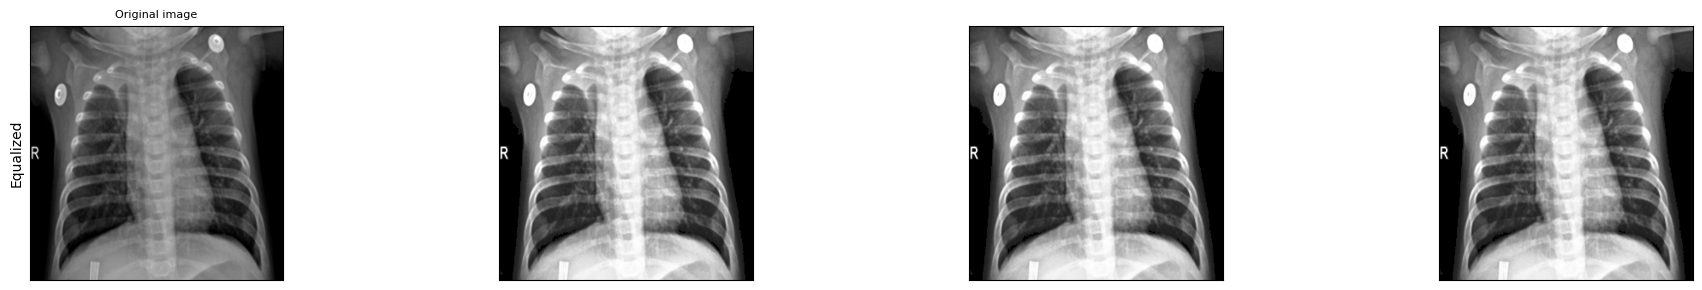

In [ ]:
# Apply and plot histogram equalization
apply_and_plot_transform(T.functional.equalize, orig_img, n_times=3, title='Equalized')

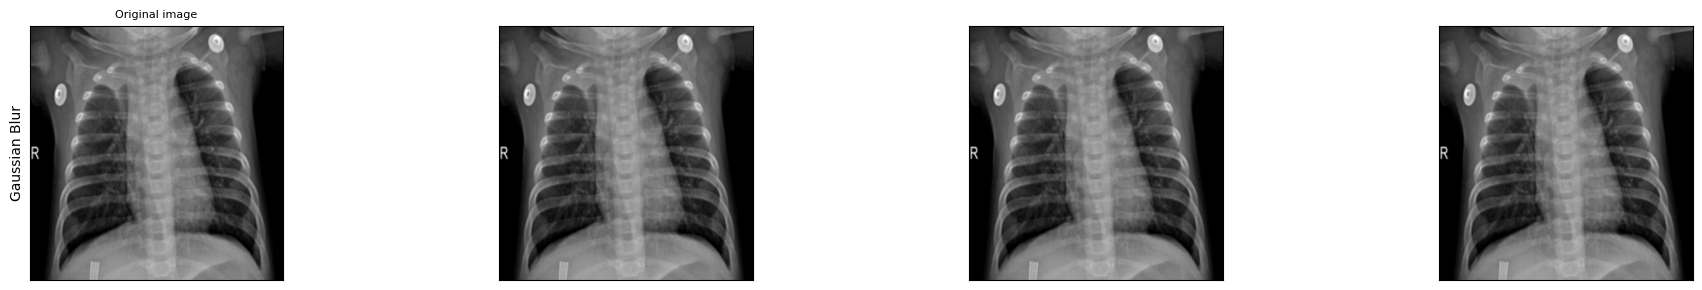

In [ ]:
# Apply and plot Gaussian blur
apply_and_plot_transform(T.GaussianBlur(kernel_size=(5, 5), sigma=0.3), orig_img, n_times=3, title='Gaussian Blur')

### Applying the transformations to the entire datset

In [ ]:
from torchvision.utils import save_image  # Import save_image for saving processed images
from tqdm import tqdm  # Import tqdm for creating progress bars

# Iterate over each row in the DataFrame using tqdm to display progress
for idx, row in tqdm(final_df.iterrows()):
    try:
        # Read the image in grayscale mode
        im = read_image(row.Filepath, mode=torchvision.io.ImageReadMode.GRAY)

        # Apply histogram equalization to the image
        imP = T.functional.equalize(im)

        # Apply Gaussian blur to the equalized image
        imP = T.functional.gaussian_blur(imP, kernel_size=(5, 5), sigma=None)

        # Ensure the directory exists before saving the image
        save_dir = f"/content/covid-19/{row.label}/"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Save the processed image to the appropriate directory
        save_image(imP / 255., os.path.join(save_dir, row.Filepath.split('/')[-1]))

    except RuntimeError as e:
        # If an error occurs, drop the problematic row from the DataFrame
        final_df.drop(idx, inplace=True)

8577it [03:39, 39.12it/s]


### Splitting the dataset into train, test and val

In [ ]:
from sklearn.model_selection import train_test_split  # Import train_test_split for dataset splitting

# Define a random state for reproducibility
state = 30

# Split the data into training and test sets, with stratification by label
train, test = train_test_split(final_df, test_size=0.3, random_state=state, shuffle=True, stratify=final_df['label'])

# Further split the test set into validation and test sets, with stratification by label
val, test = train_test_split(test, test_size=0.5, random_state=state, shuffle=True, stratify=test['label'])

# Convert the file paths from each split into lists
train_p, val_p, test_p = train.Filepath.to_list(), val.Filepath.to_list(), test.Filepath.to_list()

In [ ]:
import shutil  # Import shutil for file operations

source_dirs = ['normal', 'viral', 'covid']  # Define source directories corresponding to class labels
folds = ['train', 'val', 'test']  # Define fold names

# Create directories for each fold if they don't exist
for fold in folds:
    fold_dir = os.path.join(base_dir, fold)
    os.makedirs(fold_dir, exist_ok=True)  # Create fold directory if it doesn't exist

    for c in source_dirs:
        class_dir = os.path.join(fold_dir, c)
        os.makedirs(class_dir, exist_ok=True)  # Create class directory within fold if it doesn't exist

# Move files to their respective directories based on the fold and class
for ls, fold in zip([train_p, val_p, test_p], folds):
    for p in ls:
        destination = os.path.join(base_dir, fold, '/'.join(p.split('/')[-2:]))
        shutil.move(p, destination)

# Remove the now-empty directories for covid, normal, and viral
for source_dir in source_dirs:
    shutil.rmtree(os.path.join(base_dir, source_dir))

### Downloading all the files into the google drive

In [ ]:
from google.colab import drive

# Mount Google Drive to access it from Colab
drive.mount('/content/drive')

# Define the path to the folder you want to save
colab_folder = "/content/covid-19"

# Define the path in Google Drive where you want to save the folder
gdrive_folder = "/content/drive/MyDrive/covid-19"

# Check if the destination folder already exists in Google Drive and remove it if necessary
if os.path.exists(gdrive_folder):
    shutil.rmtree(gdrive_folder)

# Copy the entire folder from Colab to Google Drive
shutil.copytree(colab_folder, gdrive_folder)

print(f"Folder successfully copied to {gdrive_folder}")

Mounted at /content/drive
Folder successfully copied to /content/drive/MyDrive/covid-19
